In [25]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def write_fasta(fasta_name, keys, sequences):
    with open(fasta_name, "w") as f:
        for i, key in enumerate(keys):
            seq = sequences[i]
            f.write(f">{key}\n")
            f.write(f"{seq}\n")

**To check for protein sequence similarity between HPA/UniProt and HOU datasets we align proteins with mmsews easy-search. To produce the necessary aligment files, run 03.1-align.sh**

In [27]:
columns = ["query","target","fident","alnlen","mismatch",
           "gapopen","qstart","qend","tstart","tend","evalue",
           "bits","pident","nident","qlen","tlen","qcov","tcov"]
hou_hpa_aligment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/hou_hpa_alignment.m8", 
    sep="\t", header=None, names=columns)
hou_uniprot_aligment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/hou_uniprot_alignment.m8", 
    sep="\t", header=None, names=columns)

In [28]:
all_data = pd.read_csv("../datasets/intermediate/building/mapped_locations_all_datasets.csv")

hou = all_data[all_data.HOU]
hpa = all_data[all_data.hpa]
uniprot = all_data[all_data.uniprot]

In [29]:
# check that every protein in hou is in the alignment file, 
# since it should be in common with itself from at least one 
# of HPA and UniProt

s1 = set(all_data[all_data.hpa & all_data.HOU].uniprot_id.to_list())
s2 = set(hou_hpa_aligment[hou_hpa_aligment["query"] == hou_hpa_aligment["target"]].target.to_list())
assert s1 == s2

s1 = set(all_data[all_data.uniprot & all_data.HOU].uniprot_id.to_list())
s2 = set(hou_uniprot_aligment[hou_uniprot_aligment["query"] == hou_uniprot_aligment["target"]].target.to_list())
assert s1 == s2

In [30]:
def contains_string(s, l):
    return any([i in s for i in l])

#hou_rare_classes = ["peroxisomes", "endosomes", "lysosomes", "lipid-droplets"]
hou_rare_classes = ["lipid-droplets", "lysosomes"]
hou_rare_class_genes = set(hou[hou.hou_level1.apply(
        lambda s: contains_string(s, hou_rare_classes))
        ].uniprot_id.to_list())

In [7]:
hpa_thresh = 2
hou_hpa_how_common = hou_hpa_aligment.groupby("query").target.count()

#Drop a gene from HOU if it has many homologs in HPA, unless it is from a rare class, then keep in HOU
hpa_drop_from_hou = set(np.unique(hou_hpa_how_common[hou_hpa_how_common >= hpa_thresh].index.to_list()))
temp = hpa_drop_from_hou.intersection(hou_rare_class_genes)
hpa_drop_from_hou = hpa_drop_from_hou  - temp 
print(f"Saved {len(temp)} proteins from rare classes in HOU")

#HOU genes from alignment file that are not being dropped
hou_hpa_alignment_keep = set(hou_hpa_aligment["query"].unique()) - hpa_drop_from_hou

#Collect all HPA genes which are homologous to genes being kept by HOU 
drop_from_hpa  = hou_hpa_aligment[hou_hpa_aligment["query"].isin(hou_hpa_alignment_keep)].target.unique()

hpa_filt = hpa[~ hpa.uniprot_id.isin(drop_from_hpa)].reset_index(drop=True)

print(f"Number of proteins from HPA to drop: {len(drop_from_hpa)}")
print(f"Number of proteins left in HPA: {len(hpa_filt)}")
print(f"Number of proteins from HPA (int) HOU to drop from HOU: {len(hpa_drop_from_hou)}")

Saved 33 proteins from rare classes in HOU
Number of proteins from HPA to drop: 3681
Number of proteins left in HPA: 7927
Number of proteins from HPA (int) HOU to drop from HOU: 1308


In [8]:
uniprot_thresh = 10
hou_uniprot_how_common = hou_uniprot_aligment.groupby("query").target.count()

#Drop a gene from HOU if it has many homologs in UniProt, unless it is from a rare class, then keep in HOU
uniprot_drop_from_hou = set(np.unique(hou_uniprot_how_common[hou_uniprot_how_common >= uniprot_thresh].index.to_list()))
temp = uniprot_drop_from_hou.intersection(hou_rare_class_genes)
if len(temp) > 1:
    uniprot_drop_from_hou = uniprot_drop_from_hou  - temp 
    print(f"Saved {len(temp)} proteins from rare classes in HOU")

#HOU genes from alignment file that are not being dropped
hou_uniprot_alignment_keep = set(hou_uniprot_aligment["query"].unique()) - uniprot_drop_from_hou

#Collect all UniProt genes which are homologous to genes being kept by HOU 
drop_from_uniprot  = hou_uniprot_aligment[hou_uniprot_aligment["query"].isin(hou_uniprot_alignment_keep)].target.unique()

uniprot_filt = uniprot[~ uniprot.uniprot_id.isin(drop_from_uniprot)].reset_index(drop=True)

print(f"Number of proteins from UniProt to drop: {len(drop_from_uniprot)}")
print(f"Number of proteins left in UniProt: {len(uniprot_filt)}")
print(f"Number of proteins from UniProt (int) HOU to drop from HOU: {len(uniprot_drop_from_hou)}")

Saved 7 proteins from rare classes in HOU
Number of proteins from UniProt to drop: 9343
Number of proteins left in UniProt: 20906
Number of proteins from UniProt (int) HOU to drop from HOU: 214


In [9]:
drop_from_hou = set(uniprot_drop_from_hou).union(set(hpa_drop_from_hou))
hou_filt = hou[~hou.uniprot_id.isin(drop_from_hou)].reset_index(drop=True)
print(f"Total number of proteins in HOU to drop: {len(drop_from_hou)}")
print(f"Number of proteins left in HOU: {len(hou_filt)}")

Total number of proteins in HOU to drop: 1326
Number of proteins left in HOU: 3814


In [10]:
#Add columns to define different train/test sets
all_data.loc[:, "hpa_trainset"] = all_data.uniprot_id.isin(hpa_filt.uniprot_id.to_list())
all_data.loc[:, "uniprot_trainset"] = all_data.uniprot_id.isin(uniprot_filt.uniprot_id.to_list())
all_data.loc[:, "hou_testset"] = all_data.uniprot_id.isin(hou_filt.uniprot_id.to_list())
all_data.loc[:, "hpa_uniprot_combined_trainset"] = (
    ((all_data.hpa_trainset) | (all_data.uniprot_trainset)) &
    ((all_data.hpa_level1 == all_data.uni_level1) | (all_data.hpa_level1.isna()) |(all_data.uni_level1.isna()))
    )
all_data.loc[:, "hpa_uniprot_combined_human_trainset"] = all_data.hpa_uniprot_combined_trainset & all_data.human

In [11]:
#Add columns for annotations specifically for combined and combined_human trainsets
all_data.loc[
    all_data.hpa_uniprot_combined_trainset, 
    "combined_level1"
    ] = all_data.hpa_level1.where(all_data.hpa_level1.notnull(), all_data.uni_level1)

all_data.loc[
    all_data.hpa_uniprot_combined_trainset, 
    "combined_level2"
    ] = all_data.hpa_level2.where(all_data.hpa_level2.notnull(), all_data.uni_level2)

all_data.loc[
    all_data.hpa_uniprot_combined_trainset, 
    "combined_level3"
    ] = all_data.hpa_level3.where(all_data.hpa_level3.notnull(), all_data.uni_level3)

all_data.loc[
    all_data.hpa_uniprot_combined_human_trainset, 
    "combinedhuman_level1"
    ] = all_data.hpa_level1.where(all_data.hpa_level1.notnull(), all_data.uni_level1)

all_data.loc[
    all_data.hpa_uniprot_combined_human_trainset, 
    "combinedhuman_level2"
    ] = all_data.hpa_level2.where(all_data.hpa_level2.notnull(), all_data.uni_level2)

all_data.loc[
    all_data.hpa_uniprot_combined_human_trainset, 
    "combinedhuman_level3"
    ] = all_data.hpa_level3.where(all_data.hpa_level3.notnull(), all_data.uni_level3)
#all_data.loc[~ all_data.hpa_uniprot_combined_trainset, "combined_level1"] = pd.NA

In [12]:
#Sanity check that no train/testset has empty annotation

assert not all_data[all_data.hou_testset][
    [
    "hou_level1", 
    "hou_level2", 
    "hou_level3"
    ]
].isna().any().any()

assert not all_data[all_data.uniprot_trainset][
    [
    "uni_level1", 
    "uni_level2", 
    "uni_level3"
    ]
].isna().any().any()

assert not all_data[all_data.hpa_trainset][
    [
    "hpa_level1", 
    "hpa_level2", 
    "hpa_level3"
    ]
].isna().any().any()

assert not all_data[all_data.hpa_uniprot_combined_trainset][
    [
    "combined_level1", 
    "combined_level2", 
    "combined_level3"
    ]
].isna().any().any()

assert not all_data[all_data.hpa_uniprot_combined_human_trainset][
    [
    "combinedhuman_level1", 
    "combinedhuman_level2", 
    "combinedhuman_level3"
    ]
].isna().any().any()

In [13]:
#Save train/test sets in fastas for clustering
write_fasta(
    "../datasets/fastas/hpa_trainset.fasta", 
    all_data[all_data.hpa_trainset].uniprot_id.to_list(), 
    all_data[all_data.hpa_trainset].Sequence.to_list()
    )
write_fasta(
    "../datasets/fastas/uniprot_trainset.fasta", 
    all_data[all_data.uniprot_trainset].uniprot_id.to_list(), 
    all_data[all_data.uniprot_trainset].Sequence.to_list()
    )
write_fasta(
    "../datasets/fastas/hou_testset.fasta", 
    all_data[all_data.hou_testset].uniprot_id.to_list(), 
    all_data[all_data.hou_testset].Sequence.to_list()
    )
write_fasta(
    "../datasets/fastas/hpa_uniprot_combined_trainset.fasta", 
    all_data[all_data.hpa_uniprot_combined_trainset].uniprot_id.to_list(), 
    all_data[all_data.hpa_uniprot_combined_trainset].Sequence.to_list()
    )
write_fasta(
    "../datasets/fastas/hpa_uniprot_combined_human_trainset.fasta", 
    all_data[all_data.hpa_uniprot_combined_human_trainset].uniprot_id.to_list(), 
    all_data[all_data.hpa_uniprot_combined_human_trainset].Sequence.to_list()
    )

**We rerun the easy-search alignment again on the new fasta files to ensure that there are no common homologs between trainsets and HOU. Run 03.2-check.sh and then make sure that all allignment files are empty**

**Now we need to partition the HPA and Uniprot training sets into k folds such that no pair of proteins across folds are homologues. We find clusters by runnning easy-search alignment on trainsets against themelves. To produce the necessary alignment files run 03.3-cluster.sh**

In [40]:
#Gather cluster information
hpa_hpa_aligment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/hpa_hpa_alignment.m8", 
    sep="\t", header=None, names=columns)
uniprot_uniprot_aligment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/uniprot_uniprot_alignment.m8", 
    sep="\t", header=None, names=columns)
combined_combined_aligment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/combined_combined_alignment.m8", 
    sep="\t", header=None, names=columns)
combinedhuman_combinedhuman_alignment= pd.read_csv(
    "../datasets/intermediate/mmseqs_out/combinedhuman_combinedhuman_alignment.m8", 
    sep="\t", header=None, names=columns)

#Ignore when gene compared to itself
hpa_hpa_aligment = hpa_hpa_aligment[
    hpa_hpa_aligment["query"] != hpa_hpa_aligment["target"]]
uniprot_uniprot_aligment = uniprot_uniprot_aligment[
    uniprot_uniprot_aligment["query"] != uniprot_uniprot_aligment["target"]]
combined_combined_alignment = combined_combined_aligment[
    combined_combined_aligment["query"] != combined_combined_aligment["target"]]
combinedhuman_combinedhuman_alignment = combinedhuman_combinedhuman_alignment[
    combinedhuman_combinedhuman_alignment["query"] != combinedhuman_combinedhuman_alignment["target"]]

Now we run single-linkage clustering algorithm

In [41]:
def single_linkage_clusters(gene_ids, alignment):

    keys_wrapped = [{key} for key in gene_ids]
    values = [i for i in range(len(gene_ids))]
    cluster_ids = dict(zip(gene_ids, values))
    clusters = dict(zip(values, keys_wrapped))

    for i, row in alignment.iterrows():
        gene1 = row["query"]
        gene2 = row["target"]
        id1 = cluster_ids[gene1]
        id2 = cluster_ids[gene2]

        if id1 != id2:
            min_id = min(id1, id2)
            drop_id = max(id1, id2)

            #Add all genes to min_id cluster
            add = clusters[drop_id]
            clusters[min_id].update(add)
            
            #Remove other cluster
            clusters.pop(drop_id)

            #Update cluser ids for all moved genes
            for gene in add:
                cluster_ids[gene] = min_id

    return cluster_ids, clusters

In [42]:
hpa_cluster_ids, hpa_clusters = single_linkage_clusters(
    all_data[all_data.hpa_trainset].uniprot_id.to_list(), 
    hpa_hpa_aligment)

uniprot_cluster_ids, uniprot_clusters = single_linkage_clusters(
    all_data[all_data.uniprot_trainset].uniprot_id.to_list(), 
    uniprot_uniprot_aligment)

combined_cluster_ids, combined_clusters = single_linkage_clusters(
    all_data[all_data.hpa_uniprot_combined_trainset].uniprot_id.to_list(), 
    combined_combined_alignment)

combinedhuman_cluster_ids, combinedhuman_clusters = single_linkage_clusters(
    all_data[all_data.hpa_uniprot_combined_human_trainset].uniprot_id.to_list(), 
    combinedhuman_combinedhuman_alignment)

In [43]:
# Sanity check that sum of all clusters is equal to whole dataset

total_clusters = set(sum([list(v) for k,v in hpa_clusters.items()], []))
total_train = set(all_data[all_data.hpa_trainset].uniprot_id)
assert total_clusters == total_train

total_clusters = set(sum([list(v) for k,v in uniprot_clusters.items()], []))
total_train = set(all_data[all_data.uniprot_trainset].uniprot_id)
assert total_clusters == total_train

total_clusters = set(sum([list(v) for k,v in combined_clusters.items()], []))
total_train = set(all_data[all_data.hpa_uniprot_combined_trainset].uniprot_id)
assert total_clusters == total_train

total_clusters = set(sum([list(v) for k,v in combinedhuman_clusters.items()], []))
total_train = set(all_data[all_data.hpa_uniprot_combined_human_trainset].uniprot_id)
assert total_clusters == total_train

In [44]:
# Level1 has hierarchical labels for "vesicles" and "cytoskeleton" 
# So for the sake of training models we want to include these labels
# if one of the subcompartments is in the annotation

def duplicate_vesicle_cytoskeleton(locs):
    cytoskel_sub = {
        "actin-filaments",
        "intermediate-filaments",
        "microtubules",
        "centrosome"
    }
    vesicle_sub = {
        "lysosomes",
        "endosomes",
        "peroxisomes",
        "lipid-droplets"
    }
    locs = set(locs.split(";"))
    if len(locs.intersection(cytoskel_sub)) != 0:
        locs.add("cytoskeleton")
    if len(locs.intersection(vesicle_sub)) != 0:
        locs.add("vesicles")
    locs = ";".join(list(locs))
    return locs

all_data.hou_level1 = all_data.hou_level1.apply(
    lambda x: duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
)

all_data.hpa_level1 = all_data.hpa_level1.apply(
    lambda x: duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
)

all_data.uni_level1 = all_data.uni_level1.apply(
    lambda x: duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
)

all_data.combined_level1 = all_data.combined_level1.apply(
    lambda x: duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
)

all_data.combinedhuman_level1 = all_data.combinedhuman_level1.apply(
    lambda x: duplicate_vesicle_cytoskeleton(x) if pd.notnull(x) else x
)

In [45]:
def get_least_common_locs(locs):
    locs = locs.str.split(";").to_list()
    l = sum(locs, [])
    c = Counter(l)
    least_common_locs = sorted(c, key=lambda x:-c[x])
    idxs = [min([least_common_locs.index(i) for i in loc]) for loc in locs]
    locs = [least_common_locs[i] for i in idxs]
    return locs

In [46]:
hpa_proteins = all_data[all_data.hpa_trainset].uniprot_id.to_list()
hpa_locs = get_least_common_locs(all_data[all_data.hpa_trainset].hpa_level1)
hpa_groups = list(hpa_cluster_ids.values())

In [47]:
hpa_proteins = all_data[all_data.hpa_trainset].uniprot_id.to_list()
hpa_locs = get_least_common_locs(all_data[all_data.hpa_trainset].hpa_level1)
hpa_groups = list(hpa_cluster_ids.values())
sgkf = StratifiedGroupKFold(n_splits=5)
splits = sgkf.split(hpa_proteins, y=hpa_locs, groups=hpa_groups)
hpa_folds = [-1 for i in range(len(hpa_proteins))]
for i, (train_index, test_index) in enumerate(splits):
    for j in test_index:
        hpa_folds[j] = i
all_data.loc[all_data.hpa_trainset, "hpa_fold"] = hpa_folds


uni_proteins = all_data[all_data.uniprot_trainset].uniprot_id.to_list()
uni_locs = get_least_common_locs(all_data[all_data.uniprot_trainset].uni_level1)
uni_groups = list(uniprot_cluster_ids.values())
sgkf = StratifiedGroupKFold(n_splits=5)
splits = sgkf.split(uni_proteins, y=uni_locs, groups=uni_groups)
uni_folds = [-1 for i in range(len(uni_proteins))]
for i, (train_index, test_index) in enumerate(splits):
    for j in test_index:
        uni_folds[j] = i
all_data.loc[all_data.uniprot_trainset, "uni_fold"] = uni_folds


combined_proteins = all_data[all_data.hpa_uniprot_combined_trainset].uniprot_id.to_list()
combined_locs = get_least_common_locs(all_data[all_data.hpa_uniprot_combined_trainset].combined_level1)
combined_groups = list(combined_cluster_ids.values())
sgkf = StratifiedGroupKFold(n_splits=5)
splits = sgkf.split(combined_proteins, y=combined_locs, groups=combined_groups)
combined_folds = [-1 for i in range(len(combined_proteins))]
for i, (train_index, test_index) in enumerate(splits):
    for j in test_index:
        combined_folds[j] = i
all_data.loc[all_data.hpa_uniprot_combined_trainset, "combined_fold"] = combined_folds



combinedhuman_proteins = all_data[all_data.hpa_uniprot_combined_human_trainset].uniprot_id.to_list()
combinedhuman_locs = get_least_common_locs(all_data[all_data.hpa_uniprot_combined_human_trainset].combinedhuman_level1)
combinedhuman_groups = list(combinedhuman_cluster_ids.values())
sgkf = StratifiedGroupKFold(n_splits=5)
splits = sgkf.split(combinedhuman_proteins, y=combinedhuman_locs, groups=combinedhuman_groups)
combinedhuman_folds = [-1 for i in range(len(combinedhuman_proteins))]
for i, (train_index, test_index) in enumerate(splits):
    for j in test_index:
        combinedhuman_folds[j] = i
all_data.loc[all_data.hpa_uniprot_combined_human_trainset, "combinedhuman_fold"] = combinedhuman_folds


In [48]:
hpa_trainset = all_data[all_data.hpa_trainset][
    ["uniprot_id", "hpa_level1", "hpa_level2", "hpa_level3", "hpa_fold"]
    ]

assert not hpa_trainset.isna().any().any()

uniprot_trainset = all_data[all_data.uniprot_trainset][
    ["uniprot_id", "uni_level1", "uni_level2", "uni_level3", "uni_fold"]
    ]

assert not uniprot_trainset.isna().any().any()

hpa_uniprot_combined_trainset = all_data[all_data.hpa_uniprot_combined_trainset][
    ["uniprot_id", "combined_level1", "combined_level2", "combined_level3", "combined_fold"]
    ]

assert not hpa_uniprot_combined_trainset.isna().any().any()

hpa_uniprot_combined_human_trainset = all_data[all_data.hpa_uniprot_combined_human_trainset][
    ["uniprot_id", "combinedhuman_level1", "combinedhuman_level2", 
    "combinedhuman_level3", "combinedhuman_fold"]
    ]

assert not hpa_uniprot_combined_human_trainset.isna().any().any()

In [49]:
#Make sure that every trainset has folds
assert ~ all_data[all_data.hpa_trainset].hpa_fold.isnull().any()
assert ~ all_data[all_data.uniprot_trainset].uni_fold.isnull().any()
assert ~ all_data[all_data.hpa_uniprot_combined_trainset].combined_fold.isnull().any()
assert ~ all_data[all_data.hpa_uniprot_combined_human_trainset].combinedhuman_fold.isnull().any()

# Sanity check that no overlap between trainsets and hou testset
assert ~ (all_data.hou_testset & all_data.hpa_trainset).any()
assert ~ (all_data.hou_testset & all_data.uniprot_trainset).any()
assert ~ (all_data.hou_testset & all_data.hpa_uniprot_combined_trainset).any()
assert ~ (all_data.hou_testset & all_data.hpa_uniprot_combined_human_trainset).any()

# Make sure no proteins are repeated
assert ~ (all_data.uniprot_id.value_counts()>1).any()

In [50]:
def show_fold_balance(trainset_col, fold_col, loc_col):
    
    groups = all_data[all_data[trainset_col]].groupby(fold_col)
    df = []
    for i, group in groups:
        fold = group[fold_col].iloc[0]
        locs = group[loc_col].str.split(";")
        locs = sum(locs, [])
        c = Counter(locs)
        locs = list(c.keys())
        counts = list(c.values())
        fold = [fold for i in range(len(locs))]
        df.append(pd.DataFrame(
            np.array([locs, counts, fold]).T, 
            columns=["loc", "count", "fold"])
            )
    df = pd.concat(df)
    df["count"] = df["count"].astype(int)
    df = df.sort_values(by=['loc', 'fold'])
    ax = sns.barplot(data=df, x="loc", y="count", hue="fold")
    #ax.set_yscale('log')
    df = df.pivot(index="loc", columns=["fold"], values="count")
    display(df)
    plt.xticks(rotation=90)
    plt.title(trainset_col)
    plt.show()

fold,0.0,1.0,2.0,3.0,4.0
loc,,,,,
actin-filaments,48.0,60.0,49.0,64.0,47.0
centrosome,73.0,78.0,71.0,65.0,73.0
cytoskeleton,176.0,193.0,166.0,177.0,178.0
cytosol,644.0,603.0,629.0,644.0,638.0
endoplasmic-reticulum,56.0,57.0,52.0,55.0,56.0
endosomes,1.0,3.0,2.0,NaN,1.0
golgi-apparatus,158.0,163.0,172.0,161.0,148.0
intermediate-filaments,26.0,23.0,15.0,27.0,30.0
lipid-droplets,3.0,10.0,4.0,1.0,3.0


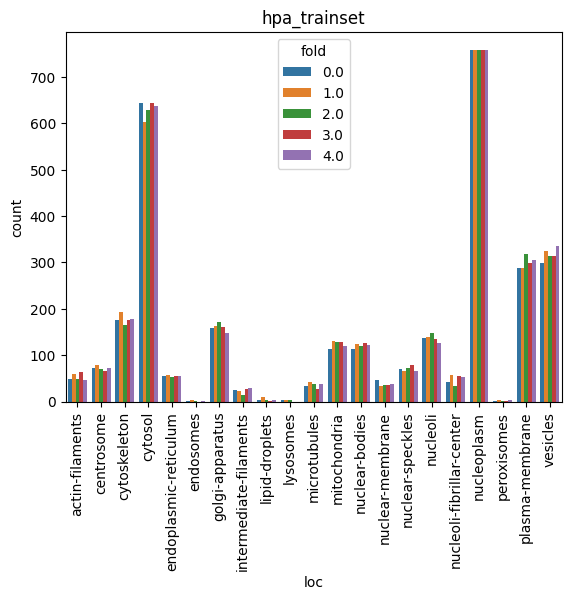

fold,0.0,1.0,2.0,3.0,4.0
loc,,,,,
actin-filaments,74.0,83.0,82.0,103.0,85.0
centrosome,61.0,50.0,47.0,50.0,50.0
cytoskeleton,305.0,363.0,325.0,357.0,311.0
cytosol,1499.0,1499.0,1499.0,1499.0,1499.0
endoplasmic-reticulum,353.0,348.0,344.0,351.0,340.0
endosomes,106.0,121.0,88.0,95.0,124.0
golgi-apparatus,194.0,194.0,204.0,180.0,200.0
lipid-droplets,15.0,21.0,24.0,40.0,21.0
lysosomes,43.0,59.0,49.0,56.0,58.0


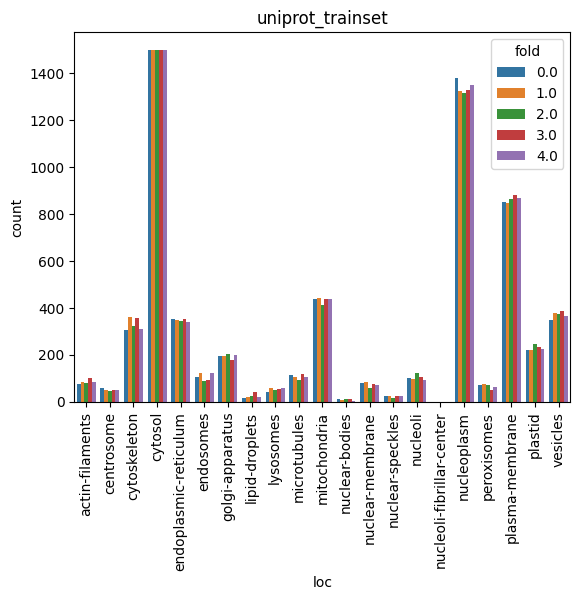

fold,0.0,1.0,2.0,3.0,4.0
loc,,,,,
actin-filaments,133,105,128,107,130
centrosome,105,95,97,119,109
cytoskeleton,456,441,470,437,471
cytosol,1944,1944,1944,1944,1944
endoplasmic-reticulum,381,368,365,359,390
endosomes,80,110,82,106,116
golgi-apparatus,300,316,334,307,302
intermediate-filaments,23,21,14,20,9
lipid-droplets,15,37,20,17,49


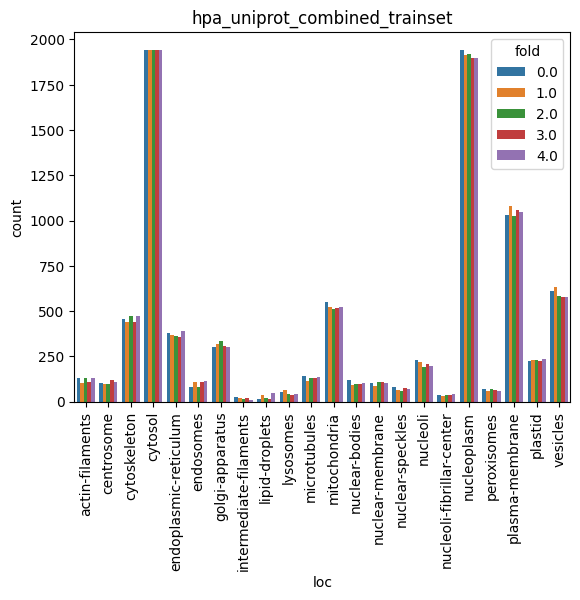

fold,0.0,1.0,2.0,3.0,4.0
loc,,,,,
actin-filaments,51,65,56,45,40
centrosome,76,82,81,73,87
cytoskeleton,190,211,193,181,188
cytosol,649,658,666,687,665
endoplasmic-reticulum,92,95,118,104,87
endosomes,20,26,28,18,21
golgi-apparatus,145,159,152,172,165
intermediate-filaments,19,20,18,10,20
lipid-droplets,9,4,3,8,7


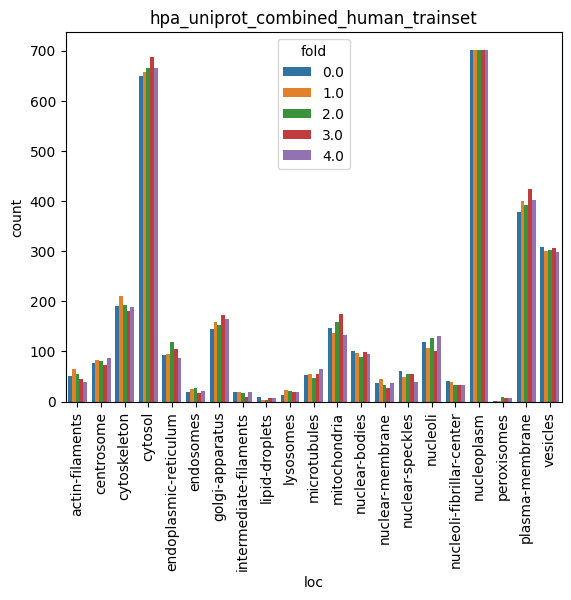

In [51]:
# Check that classes are balanced between folds for each class
show_fold_balance("hpa_trainset", "hpa_fold", "hpa_level1")
show_fold_balance("uniprot_trainset", "uni_fold", "uni_level1")
show_fold_balance("hpa_uniprot_combined_trainset", "combined_fold", "combined_level1")
show_fold_balance("hpa_uniprot_combined_human_trainset", "combinedhuman_fold", "combinedhuman_level1")

In [52]:
hou_testset = all_data[all_data.hou_testset][
    ["uniprot_id", "ensembl_id", "hou_level1", 
    "hou_level2", "hou_level3", "Sequence"]
    ].reset_index(drop=True)
hou_testset.rename(
    {"hou_level1": "level1", 
    "hou_level2": "level2", 
    "hou_level3": "level3",
    "Sequence": "sequence"},
    axis=1, inplace=True)

hpa_trainset = all_data[all_data.hpa_trainset][
    ["uniprot_id", "ensembl_id", "hpa_level1", 
    "hpa_level2", "hpa_level3", "hpa_fold", "Sequence"]
    ].reset_index(drop=True)
hpa_trainset.rename(
    {"hpa_level1": "level1", 
    "hpa_level2": "level2", 
    "hpa_level3": "level3",
    "hpa_fold": "fold",
    "Sequence": "sequence"},
    axis=1, inplace=True)


uniprot_trainset = all_data[all_data.uniprot_trainset][
    ["uniprot_id", "ensembl_id", "uni_level1", 
    "uni_level2", "uni_level3", "uni_fold", "Sequence"]
    ].reset_index(drop=True)
uniprot_trainset.rename(
    {"uni_level1": "level1", 
    "uni_level2": "level2", 
    "uni_level3": "level3",
    "uni_fold": "fold", 
    "Sequence": "sequence"},
    axis=1, inplace=True)


hpa_uniprot_combined_trainset = all_data[all_data.hpa_uniprot_combined_trainset][
    ["uniprot_id", "ensembl_id", "combined_level1", 
    "combined_level2", "combined_level3", "combined_fold", "Sequence"]
    ].reset_index(drop=True)
hpa_uniprot_combined_trainset.rename(
    {"combined_level1": "level1", 
    "combined_level2": "level2", 
    "combined_level3": "level3",
    "combined_fold": "fold",
    "Sequence": "sequence"},
    axis=1, inplace=True)


hpa_uniprot_combined_human_trainset = all_data[all_data.hpa_uniprot_combined_human_trainset][
    ["uniprot_id", "ensembl_id", "combinedhuman_level1", 
    "combinedhuman_level2", "combinedhuman_level3", "combinedhuman_fold", "Sequence"]
    ].reset_index(drop=True)
hpa_uniprot_combined_human_trainset.rename(
    {"combinedhuman_level1": "level1", 
    "combinedhuman_level2": "level2", 
    "combinedhuman_level3": "level3",
    "combinedhuman_fold": "fold",
    "Sequence": "sequence"},
    axis=1, inplace=True)

In [53]:
# Save Data

all_data.to_csv("../datasets/intermediate/building/all_data_w_folds.csv", index=False)

hou_testset.to_csv("../datasets/final/hou_testset.csv", index=False)

hpa_trainset.to_csv("../datasets/final/hpa_trainset.csv", index=False)

uniprot_trainset.to_csv("../datasets/final/uniprot_trainset.csv", index=False)

hpa_uniprot_combined_trainset.to_csv("../datasets/final/hpa_uniprot_combined_trainset.csv", index=False)

hpa_uniprot_combined_human_trainset.to_csv("../datasets/final/hpa_uniprot_combined_human_trainset.csv", index=False)

keys = all_data.uniprot_id.to_list()
seqs = all_data.Sequence.to_list()
write_fasta("../datasets/fastas/all_datasets.fasta", keys, seqs)

In [55]:
assert hou_testset.level1.notnull().all()
assert hpa_trainset.level1.notnull().all()
assert uniprot_trainset.level1.notnull().all()
assert hpa_uniprot_combined_trainset.level1.notnull().all()
assert hpa_uniprot_combined_human_trainset.level1.notnull().all()

assert hou_testset.level2.notnull().all()
assert hpa_trainset.level2.notnull().all()
assert uniprot_trainset.level2.notnull().all()
assert hpa_uniprot_combined_trainset.level2.notnull().all()
assert hpa_uniprot_combined_human_trainset.level2.notnull().all()


assert hou_testset.level3.notnull().all()
assert hpa_trainset.level3.notnull().all()
assert uniprot_trainset.level3.notnull().all()
assert hpa_uniprot_combined_trainset.level3.notnull().all()
assert hpa_uniprot_combined_human_trainset.level3.notnull().all()


print(len(hou_testset))
print(len(hpa_trainset))
print(len(uniprot_trainset))
print(len(hpa_uniprot_combined_trainset))
print(len(hpa_uniprot_combined_human_trainset))

3814
7927
20906
26436
8594


In [67]:
#Double check that veiscles and cytoskeleton are repeated in level1 for all datasets if subcompartment is included
def check_vesicle_cytoskeleton(locs):
    cytoskel_sub = {
        "actin-filaments",
        "intermediate-filaments",
        "microtubules",
        "centrosome"
    }
    vesicle_sub = {
        "lysosomes",
        "endosomes",
        "peroxisomes",
        "lipid-droplets"
    }
    locs = set(locs.split(";"))
    b = True
    if len(locs.intersection(cytoskel_sub)) != 0:
        b = b and ("cytoskeleton" in locs)
    if len(locs.intersection(vesicle_sub)) != 0:
        b = b and ("vesicles" in locs)
    
    return b


assert hou_testset.level1.apply(check_vesicle_cytoskeleton).all()
assert hpa_trainset.level1.apply(check_vesicle_cytoskeleton).all()
assert uniprot_trainset.level1.apply(check_vesicle_cytoskeleton).all()
assert hpa_uniprot_combined_trainset.level1.apply(check_vesicle_cytoskeleton).all()
assert hpa_uniprot_combined_human_trainset.level1.apply(check_vesicle_cytoskeleton).all()